# Detecting Fraudulent Insurance Claims

Tutorial and support from TA Phillip Back

#### Business Problem

1. Insurance claims are a major target for fraud, both opportunistic as well as planned/organized.
2. The costs of fraudulent claims can be substantial.
3. Manual examination of the claims is impractical and expensive due to large volume of insurance claims.

*Thus, the goal is to identify and flag fraudulent claims early in their life cycle.*


#### Keywords
`fraud detection`, `decision trees`, `exploratory data analysis (EDA)`, `data visualization`, `data preprocessing`

## Import libraries

In [1]:
import numpy as np 
import pandas as pd 

# visualize
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import matplotlib.ticker as mtick # for percentage ticks

# model
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder #OneHotEncoding
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix 
from sklearn.metrics import plot_confusion_matrix, auc, roc_curve

# decision tree plot
import pydotplus
from IPython.display import Image

## 1. Load data

In [2]:
data = pd.read_csv('insurance_fraud_data.txt') 
data.head() 

,claim_id,customer_id,age,gender,incident_cause,days_to_incident,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,54004764,21868593,32,Female,Driver error,225,Auto,No,Material only,2980.0,1,No
1,33985796,75740424,60,Female,Crime,11874,Home,Unknown,Material only,2980.0,3,No
2,53522022,30308357,27,Female,Other driver error,4,Auto,No,Material only,3369.5,1,Yes
3,13015401,47830476,39,Female,Natural causes,5278,Auto,No,Material only,1680.0,1,No
4,22890252,19269962,47,Male,Crime,2335,Auto,No,Material only,2680.0,1,No


## 2. Exploratory data analysis (EDA)

Understand the structure, variables types, and values we are dealing with.

In [3]:
data.shape

(1100, 12)

The dataset has 1100 rows (entries/instances/observations) and 12 columns (features). 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   claim_id             1100 non-null   int64  
 1   customer_id          1100 non-null   int64  
 2   age                  1100 non-null   int64  
 3   gender               1100 non-null   object 
 4   incident_cause       1100 non-null   object 
 5   days_to_incident     1100 non-null   int64  
 6   claim_area           1100 non-null   object 
 7   police_report        1100 non-null   object 
 8   claim_type           1100 non-null   object 
 9   claim_amount         1100 non-null   float64
 10  total_policy_claims  1100 non-null   int64  
 11  fraudulent           1100 non-null   object 
dtypes: float64(1), int64(5), object(6)
memory usage: 103.2+ KB


Observations:
- No missing values (all variables show 1100 entries)
- no NaN values 
- mostly int and float values, but also some object/strings (these require further attention)


In [5]:
data.describe().round()

,claim_id,customer_id,age,days_to_incident,claim_amount,total_policy_claims
count,1100.0,1100.0,1100.0,1100.0,1100.0,1100.0
mean,48838190.0,50874698.0,48.0,2814.0,12318.0,2.0
std,29188060.0,28461020.0,18.0,2785.0,13688.0,1.0
min,26832.0,154557.0,18.0,2.0,1000.0,1.0
25%,23815805.0,26791756.0,33.0,636.0,1880.0,1.0
50%,48539331.0,49855152.0,47.0,2042.0,2750.0,1.0
75%,74074466.0,75949511.0,63.0,4154.0,23965.0,2.0
max,99775483.0,99961993.0,79.0,14991.0,48150.0,8.0


## 3. Data visualization



#### Fraud vs. no fraud: absolute & relative distribution

#### Option 1: Standard pandas plotting

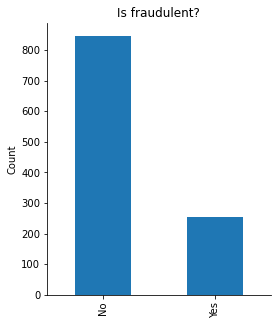

In [6]:
ax = data['fraudulent'].value_counts().plot(kind='bar', title='Is fraudulent?', figsize=(4,5))
ax.set_ylabel('Count')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

#### Option 2: Better Visualization for reporting purpose

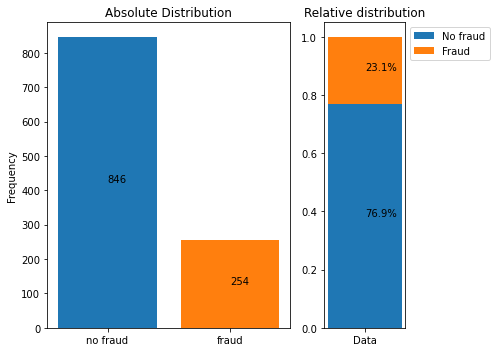

In [7]:
keys, counts = np.unique(data.fraudulent, return_counts=True)
counts_norm = counts / counts.sum()

fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[3,1]) 

# absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['no fraud', 'fraud'], counts, color=['#1f77b4','#ff7f0e']) 
ax0 = plt.title('Absolute Distribution') 
ax0 = plt.ylabel('Frequency')
ax0 = plt.text(['no fraud'], counts[0]/2, counts[0]) 
ax0 = plt.text(['fraud'], counts[1]/2, counts[1])

# normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Data'], [counts_norm[0]], label='No fraud')
ax1 = plt.bar(['Data'], [counts_norm[1]], bottom=counts_norm[0], label='Fraud')
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Relative distribution')
ax1 = plt.text(['Data'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)))
ax1 = plt.text(['Data'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)))

plt.tight_layout();

The non-fraudulent cases are accounted for about 77% of all observations. This <font color='red'>**imbalanced distribution**</font> of the response variable (`fraudulent`) occurs in many real-life Data Science problems and requires careful consideration when designing a classification model.


#### Fraudulent vs. non-fraudulent cases by incident cause

#### Option 1: Standard Pandas plotting

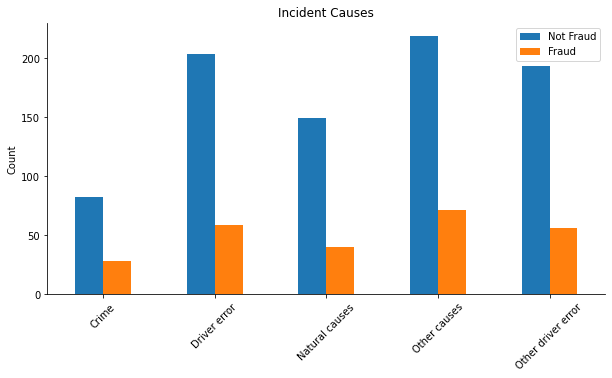

In [8]:
ax = data.groupby(['incident_cause', 'fraudulent'])['fraudulent'].count().unstack().plot.bar(figsize=(10,5), 
                                                                                             title='Incident Causes', rot=45)
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.legend(['Not Fraud', 'Fraud'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

#### Option 2: Better Visualization for reporting purpose

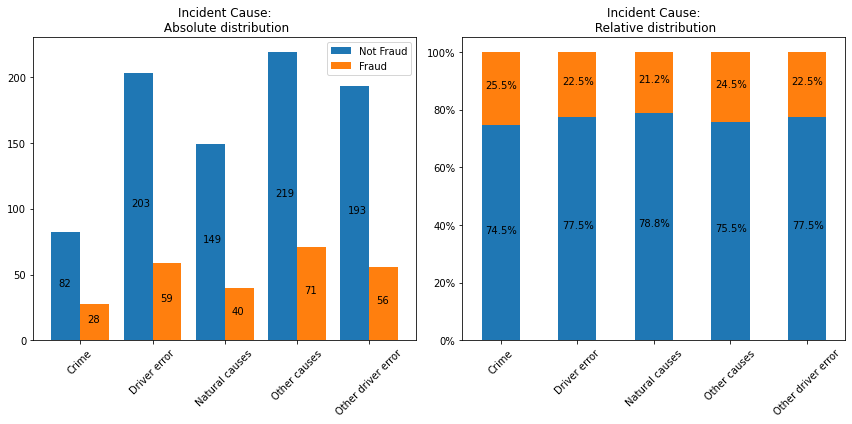

In [9]:
fig = plt.figure(figsize=(12, 6)) 

# absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['incident_cause', 'fraudulent'])['fraudulent'].count().unstack().plot.bar(rot=45, ax=plt.gca(), width=0.8)
ax1.legend(['Not Fraud', 'Fraud'])
plt.title('Incident Cause:\n Absolute distribution') 
plt.xlabel('')
# plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x()+0.1, p.get_height() * 0.5))

# relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['incident_cause','fraudulent'])['fraudulent'].size().groupby(level=0).apply(
                    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=45, ax=plt.gca(), width=0.5)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.get_legend().remove()
plt.title('Incident Cause:\n Relative distribution') 
plt.xlabel('')

# plot bar labels
for p, q in zip(ax2.patches[0:5], ax2.patches[5:10]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x() + 0.05, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x() + 0.05, q.get_height()/2+p.get_height()))

plt.tight_layout();

Almost equal distribution of fraudulent vs. non-fraudulent cases amongst the 5 incident causes. Thus, the variable `incident_cause` is probably not a good predictor for the "fraudulentness" of a claim.

#### Days to incident distribution

The time that has elapsed between signing the insurance policy and when the first claim was reported.

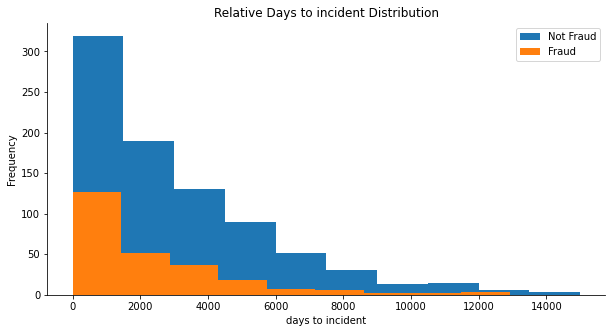

In [10]:
ax = data['days_to_incident'].loc[data['fraudulent'] == 'No'].plot.hist(bins=10, label='no fraud', figsize=(10,5))
ax = data['days_to_incident'].loc[data['fraudulent'] == 'Yes'].plot.hist(bins=9, label='fraud')
ax.set_xlabel('days to incident')
ax.set_title('Relative Days to incident Distribution')
ax.legend(['Not Fraud', 'Fraud'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

Fraudulent cases appear to be reported closer to the signing day. 

#### Fraudulent vs. non-fraudulent cases by claim area

#### Option 1: Standard pandas plotting

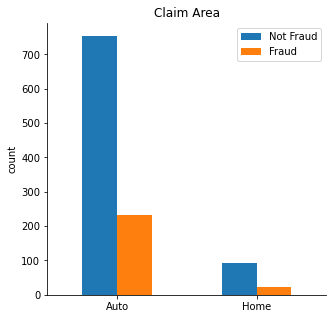

In [11]:
ax = data.groupby(['claim_area', 'fraudulent'])['fraudulent'].count().unstack().plot.bar(title='Claim Area', rot=0, figsize=(5,5))
ax.set_xlabel('')
ax.set_ylabel('count')
ax.legend(['Not Fraud', 'Fraud'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

--> Again, an almost equal distribution of fraudulent vs. non-fraudulent cases amongst the 2 claim areas "auto" and "home". 

Thus, the variable `claim_area` is probably not a good predictor for the "fraudulentness" of a claim.

#### Fraudulent vs. non-fraudulent cases by claim type

Next, we plot the fraudulent vs. non-fraudulent cases and group them by the reported claim type (*injury only*, *Material and injury* or *Material only*).

#### Option 1: Standard pandas plotting

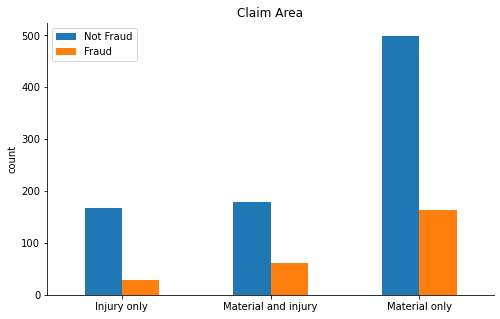

In [12]:
ax = data.groupby(['claim_type', 'fraudulent'])['fraudulent'].count().unstack().plot.bar(title='Claim Area', rot=0, figsize=(8,5))
ax.set_xlabel('')
ax.set_ylabel('count')
ax.legend(['Not Fraud', 'Fraud'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

#### Option 2: Better Visualization for reporting purpose

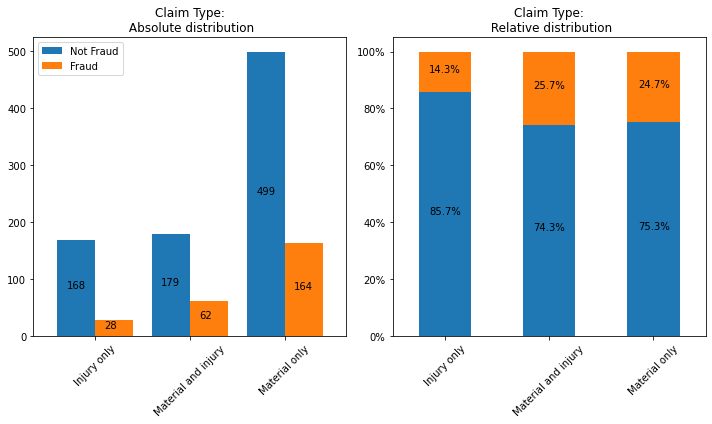

In [13]:
fig = plt.figure(figsize=(10, 6)) 

# absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['claim_type', 'fraudulent'])['fraudulent'].count().unstack().plot.bar(rot=45, ax=plt.gca(), width=0.8)
ax1.legend(['Not Fraud', 'Fraud'])
plt.title('Claim Type:\n Absolute distribution') 
plt.xlabel('')
# plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x()+0.1, p.get_height() * 0.5))

# relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['claim_type','fraudulent'])['fraudulent'].size().groupby(level=0).apply(
                    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=45, ax=plt.gca(), width=0.5)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.get_legend().remove()
plt.title('Claim Type:\n Relative distribution') 
plt.xlabel('')

# plot bar labels
for p, q in zip(ax2.patches[0:3], ax2.patches[3:6]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x() + 0.1, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x() + 0.1, q.get_height()/2+p.get_height()))

plt.tight_layout();

--> A higher proportion of fraudulent claims in the "Material and injury" and "Material only" claim type. It appears that more people try to scam the insurance company with some sort of material-related claims. 

#### Claim amount distribution

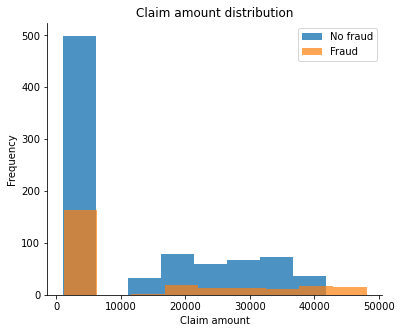

In [14]:
ax = data['claim_amount'].loc[data['fraudulent'] == 'No'].plot.hist(bins=8, alpha=0.8, label='No fraud', figsize = (6,5))
ax = data['claim_amount'].loc[data['fraudulent'] == 'Yes'].plot.hist(bins=9, alpha=0.7, label='Fraud')
ax.set_xlabel('Claim amount')
ax.set_title('Claim amount distribution')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend();

--> A slightly higher proportion of fraudulent cases in the first bin. Moreover, fraudulent claims are accounted for most of the highest claims. Above 40,000€, there are only frauds. The plot suggests that `claim amount` might be an important variable in predicting fraudulent cases.

## 4. Data cleaning & pre-processing

In [15]:
data.head()

,claim_id,customer_id,age,gender,incident_cause,days_to_incident,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,54004764,21868593,32,Female,Driver error,225,Auto,No,Material only,2980.0,1,No
1,33985796,75740424,60,Female,Crime,11874,Home,Unknown,Material only,2980.0,3,No
2,53522022,30308357,27,Female,Other driver error,4,Auto,No,Material only,3369.5,1,Yes
3,13015401,47830476,39,Female,Natural causes,5278,Auto,No,Material only,1680.0,1,No
4,22890252,19269962,47,Male,Crime,2335,Auto,No,Material only,2680.0,1,No


### Remove variables that have no explanatory power

The variables `claim_id` and `customer_id` are used by the insurance company as identifiers. They have no explantory power and might actually mislead the Decision Tree algorithm.

In [16]:
data.drop(['claim_id', 'customer_id'], axis=1, inplace=True)

In [17]:
data.shape

(1100, 10)

There are 1100 observations and 10 features.

### Encode categorical variables

The scikit-learn Decision Tree algorithm uses only numerical features, which are always interpreted as *continuous numeric variables*. `gender`, `incident_cause`, `claim_area`, `police_report`, `claim_type`, and `fraudulent` are of type object (they are strings). Thus, they have to be encoded to be readable for the Decision Tree model.

In [18]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1100 non-null   int64  
 1   gender               1100 non-null   object 
 2   incident_cause       1100 non-null   object 
 3   days_to_incident     1100 non-null   int64  
 4   claim_area           1100 non-null   object 
 5   police_report        1100 non-null   object 
 6   claim_type           1100 non-null   object 
 7   claim_amount         1100 non-null   float64
 8   total_policy_claims  1100 non-null   int64  
 9   fraudulent           1100 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 86.1+ KB


In [19]:
label_encoding = {"fraudulent": {"No": 0, "Yes": 1}}
data.replace(label_encoding, inplace=True)
data.head(2)

,age,gender,incident_cause,days_to_incident,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,32,Female,Driver error,225,Auto,No,Material only,2980.0,1,0
1,60,Female,Crime,11874,Home,Unknown,Material only,2980.0,3,0


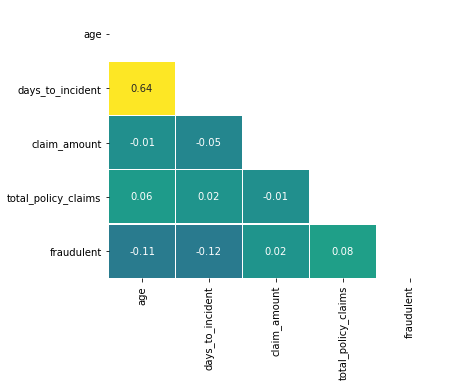

In [20]:
plt.figure(figsize=(6,5))
corr = data.corr().round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, center=0, cmap='viridis', linewidths=.5,annot=True, cbar=False);

Because the Decision Tree interprets numbers as continuous numerical features. If a category is mapped with for example 1,2,3 then it produces an order. This should be avoided --> **one hot encoding**. 

In [21]:
data = pd.get_dummies(data, columns=['gender', 'incident_cause', 'claim_area', 'police_report', 'claim_type'], 
                      prefix=['gender', 'cause', 'area', 'report', 'type'])
data.head(2).style

,age,days_to_incident,claim_amount,total_policy_claims,fraudulent,gender_Female,gender_Male,cause_Crime,cause_Driver error,cause_Natural causes,cause_Other causes,cause_Other driver error,area_Auto,area_Home,report_No,report_Unknown,report_Yes,type_Injury only,type_Material and injury,type_Material only
0,32,225,2980.000000,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
1,60,11874,2980.000000,3,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1


Some names contain white space. Besides, some is upper cases. The name should be formatted.

In [22]:
new_name = [x.lower().replace(' ', '_') for x in list(data.columns)]
data.columns = new_name
data.head(2)

,age,days_to_incident,claim_amount,total_policy_claims,fraudulent,gender_female,gender_male,cause_crime,cause_driver_error,cause_natural_causes,cause_other_causes,cause_other_driver_error,area_auto,area_home,report_no,report_unknown,report_yes,type_injury_only,type_material_and_injury,type_material_only
0,32,225,2980.0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
1,60,11874,2980.0,3,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1


## 5. Data split


<img src="Images/Split.jpg" width="300">


 

In [23]:
seed = 42
X, y = data.loc[:, data.columns != 'fraudulent'].copy(), data['fraudulent'].copy() 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Note that when copying an object containing Python objects (list of lists, 2D-array), a deep copy will copy the data, but will not do so recursively. Updating a nested data object will be reflected in the deep copy.

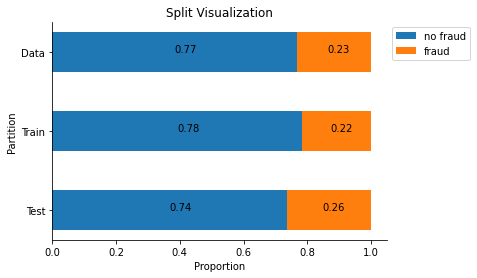

In [24]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = data['fraudulent'].value_counts() / len(data)

fig, ax = plt.subplots(figsize=(6,4))

ax.barh(['Test','Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='no fraud', height=0.5)
ax.barh(['Test','Train','Data'], [test_dist[1], train_dist[1], data_dist[1]], left=[test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='fraud', height=0.5)
ax.set_title('Split Visualization')
ax.legend(bbox_to_anchor=(1,1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['Test', 'Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], [test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a-0.02, part, str(np.round(b, 2)));

The distribution of fraudulent to non-fraudulent cases is almost equal to the distribution of the original, whole data set. 

## 6. Model building


In [25]:
# model
clf = DecisionTreeClassifier(criterion = "gini", random_state = seed, max_depth=5, min_samples_leaf=3)

# fit the training data 
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=3, random_state=42)

In [26]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

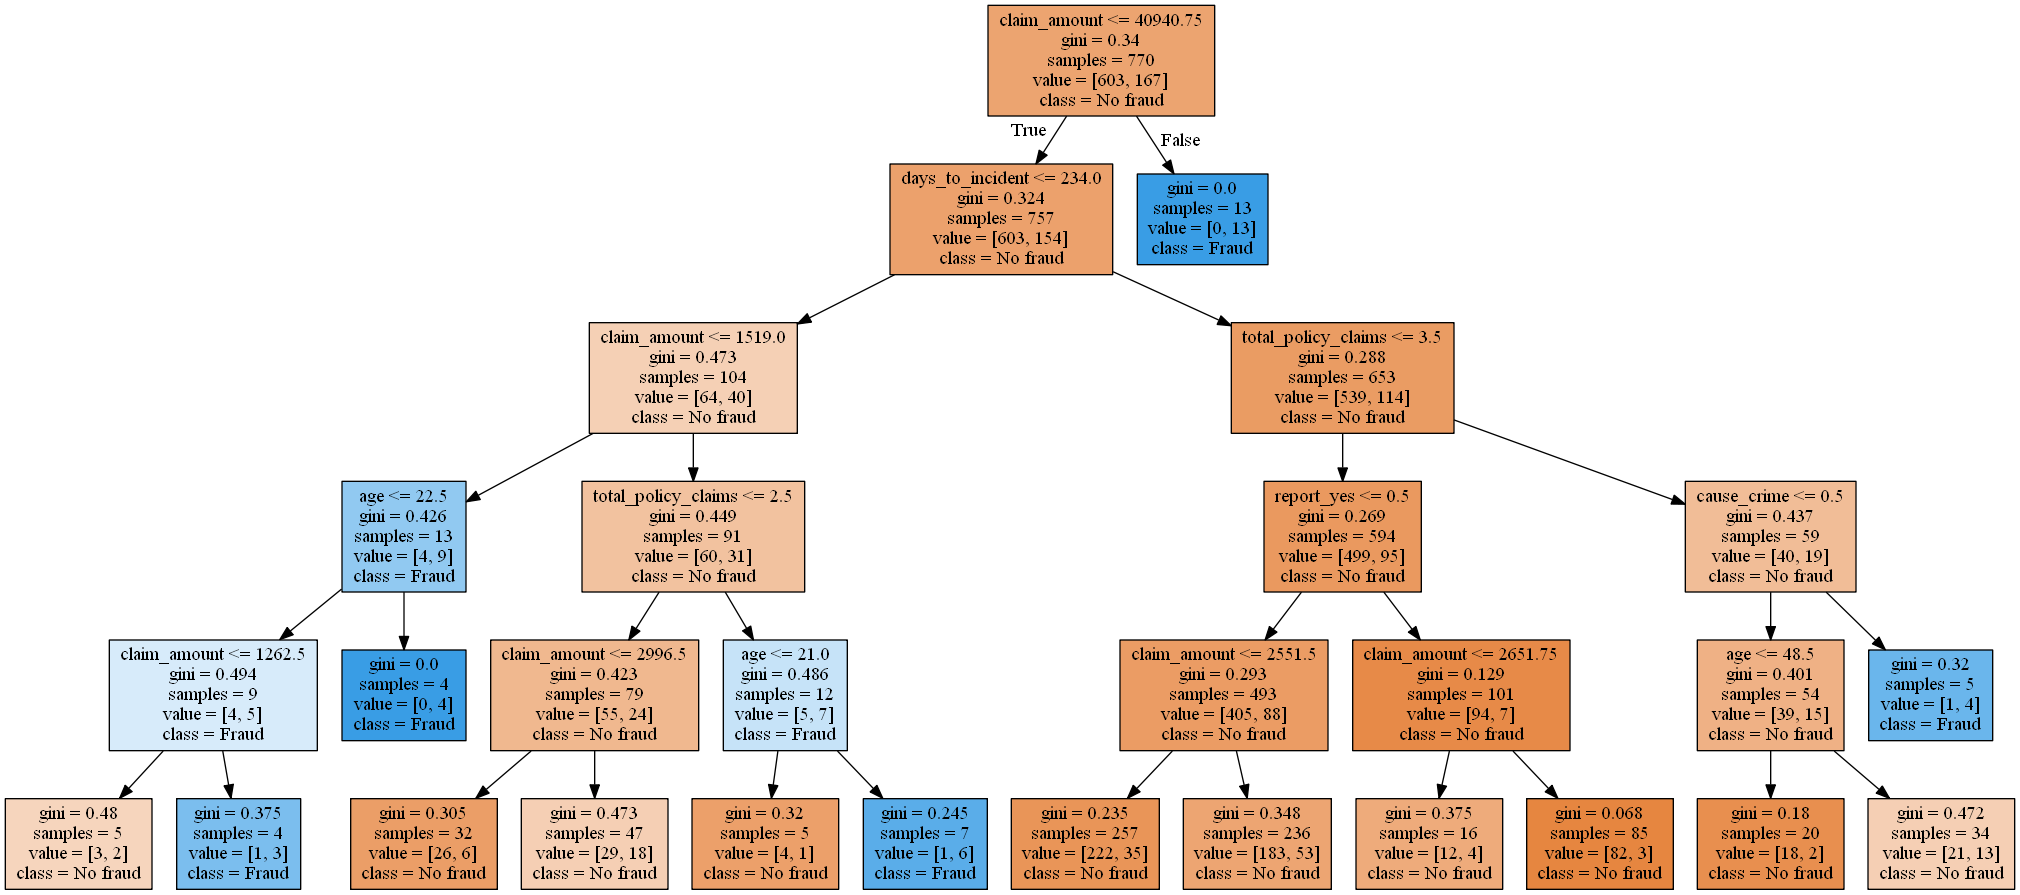

In [27]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X_train.columns, 
                                class_names=['No fraud', 'Fraud'], filled=True)

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [28]:
graph.write_png("clf.png")

True

In [29]:
importances = clf.feature_importances_
feature_order = np.array([X.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

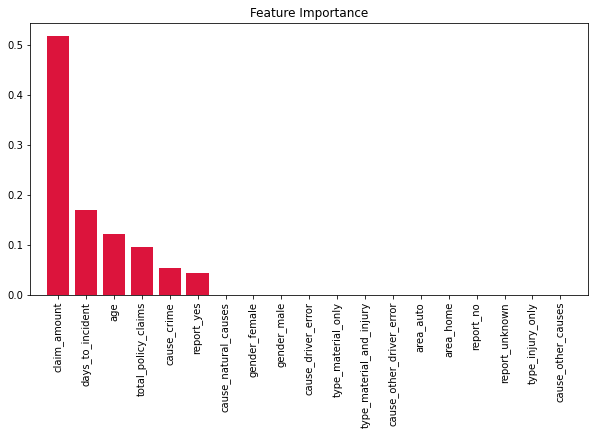

In [30]:
# plot the feature importances
plt.figure(figsize=(10,5))
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importances[i], color='crimson')
plt.xticks(range(X.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## 7. Model evaluation

### Accuracy score

In order to assess how well our model works, accuracy score is calculated - the fraction of correctly labeled cases, i.e., for which the true label $y^{(i)}$ is equal to the predicted label $\hat{y}^{(i)}$:
\begin{equation*}
    \text{Accuracy} =\dfrac{1}{N} \sum_{i=1}^{N} \mathcal{I}(\hat{y}^{(i)} = y^{(i)})
    \label{acc}
    \tag{1}
\end{equation*}


In [31]:
print ('Accuracy is: {}%'.format((accuracy_score(y_test,y_pred)*100).round(2)))

Accuracy is: 73.64%


In [32]:
print(classification_report(y_test, y_pred))  

              precision    recall  f1-score   support

           0       0.75      0.95      0.84       243
           1       0.50      0.14      0.22        87

    accuracy                           0.74       330
   macro avg       0.63      0.54      0.53       330
weighted avg       0.69      0.74      0.68       330



### Confusion matrix

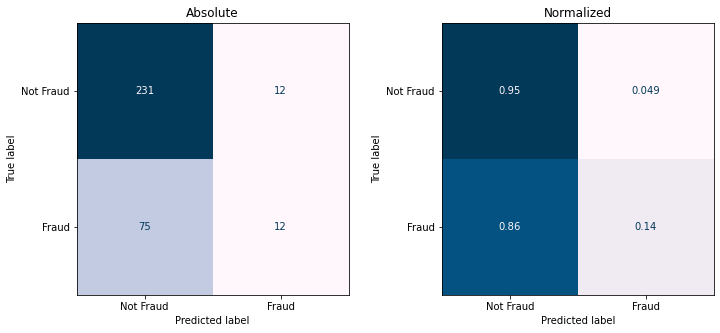

In [33]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
plot_confusion_matrix(clf, X_test, y_test, ax=ax1, cmap='PuBu', colorbar=False, 
                      display_labels=['Not Fraud', 'Fraud'])
ax1.set_title('Absolute')

ax2 = plt.subplot(122)
plot_confusion_matrix(clf, X_test, y_test, normalize='true', ax=ax2, cmap='PuBu', colorbar=None,
                      display_labels=['Not Fraud', 'Fraud'])
ax2.set_title('Normalized');

The classifier labels 95% of cases correctly as non-fraudulent, it only labels 14% correctly as fraud. It seems that the classifier predicts "non-fraudulent" most of the time. Since the data is imbalanced (77% non-fraudulent vs. 23% fraudulent), guessing "non-fraudulent" still means labeling a high proportion of claims correctly. 

### Area under the curve (AUC)

A better way of judging model performance is by calculating the Area Under the Curve (AUC) and plotting a ROC curve (Receiver Operating Characteristic). 


In [34]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
roc_auc = auc(fpr, tpr)
print('AUC score on Testing: ' + str(roc_auc.round(3)))

AUC score on Testing: 0.597


### ROC curve

We plot the ROC curve. The black dotted line represents the performance of a random pick (flipping a coin). Our model (blue line) runs above this base line, but only slightly. Using the model is better than flipping a coin, but there is still room for improvement.

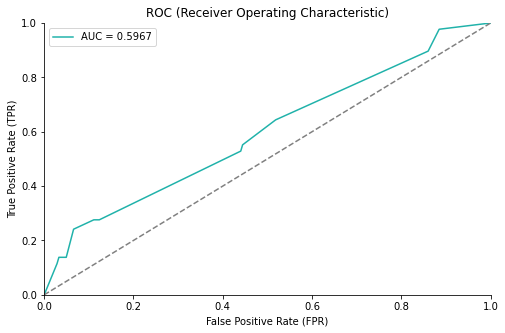

In [35]:
fig, ax = plt.subplots(figsize=(8,5))

plt.title('ROC (Receiver Operating Characteristic)')
plt.plot(fpr, tpr, 'lightseagreen', label='AUC = %0.4f'% roc_auc)
plt.legend(loc='best')
plt.plot([0,1],[0,1],color='gray', linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

## Summary

Improvement:
- Class imbalances
- Different classification algorithms (SVM, Logistic Regression, etc.)